# Loading




In [2]:
# Import useful libraries
import pandas as pd
import json
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize, StandardScaler

In [3]:
# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# returns JSON object as a dictionary
f = open('/content/drive/MyDrive/Iceberg/train.json',) # The train.json file needs to be in an "Iceberg" directory

# creating a dataframe
df_raw = pd.DataFrame(json.load(f))

# visualising the first rows
df_raw.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [5]:
# Visualising info
print(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1604 non-null   object
 1   band_1      1604 non-null   object
 2   band_2      1604 non-null   object
 3   inc_angle   1604 non-null   object
 4   is_iceberg  1604 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 62.8+ KB
None


# Data treatment

In [6]:
# Train/test split
df = df_raw.sample(frac = 0.8, random_state = 42)
df_test = df_raw.drop(df.index)

In [7]:
# Changing inc_angle from object to float64
df.replace('na', np.NaN, inplace = True) # Replacing the 'na' text in inc_angle by NaN
df['inc_angle'].astype('float', copy = False) # Casting inc_angle to float works with the NaN
df[df.inc_angle.isna()] # 133 NaN
print(df.info()) # inc_angle is now float64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1283 entries, 530 to 546
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          1283 non-null   object 
 1   band_1      1283 non-null   object 
 2   band_2      1283 non-null   object 
 3   inc_angle   1175 non-null   float64
 4   is_iceberg  1283 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 60.1+ KB
None


# Split and data selection

In [54]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error

In [50]:
# selecting the prediction target and the model features
y = df["is_iceberg"]
X = pd.DataFrame(df.band_1.to_list(), index=df.index, columns=[f"band_1_{i}" for i in range(75*75)]).join(pd.DataFrame(df.band_2.to_list(), index=df.index, columns=[f"band_2_{i}" for i in range(75*75)]))

# split data into training and validation data, for both features and target
# The split is based on a random number generator. 
# Supplying a numeric value to the random_state argument guarantees we get the same 
# split every time we run this script.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

# Model tests

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

def grid_cross_report(classifier, param_grid, scoring='f1'):

  grid_search = GridSearchCV(classifier, param_grid, cv = 5, scoring = scoring, return_train_score = True)
  grid_search.fit(X_train, y_train)

  print(f'---\nBest parameters for {classifier} :\n {grid_search.best_params_} with {scoring} score {round(grid_search.best_score_,3)}')

  best = grid_search.best_estimator_
  scores = cross_val_score(best, X_train, y_train, cv=10, scoring=scoring)
  print(f'Cross_val mean {scoring} score {round(np.mean(scores),3)} with std {round(np.std(scores),3)}')

  best.fit(X_train, y_train)
  y_pred = best.predict(X_test)

  print(f'Scores for the test sample :\n f1 : {round(f1_score(y_test, y_pred),3)}\n precision : {round(precision_score(y_test, y_pred),3)}\n recall : {round(recall_score(y_test, y_pred),3)}')

  print('Confusion matrix for the test sample :')
  cm = confusion_matrix(y_test, y_pred)
  ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Iceberg','Boat']).plot()

In [72]:
def cross_report(classifier, scoring='f1'):

  print(f'---\n{classifier}')
  scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring=scoring)
  print(f'Cross_val mean {scoring} score {round(np.mean(scores),3)} with std {round(np.std(scores),3)}')

  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)

  print(f'Scores for the test sample :\n f1 : {round(f1_score(y_test, y_pred),3)}\n precision : {round(precision_score(y_test, y_pred),3)}\n recall : {round(recall_score(y_test, y_pred),3)}')

  print('Confusion matrix for the test sample :')
  cm = confusion_matrix(y_test, y_pred)
  ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Iceberg','Boat']).plot()

## Decision Tree

---
Best parameters for DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best') :
 {'max_features': None, 'min_samples_leaf': 3} with f1 score 0.607
Cross_val mean f1 score 0.639 with std 0.025
Scores for the test sample :
 f1 : 0.694
 precision : 0.694
 recall : 0.694
Confusion matrix for the test sample :


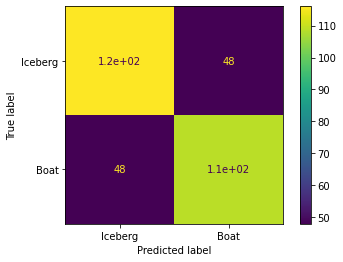

In [85]:
param_grid = [{
    'min_samples_leaf': range(2,4,1),
    'max_features': [None]
}]
grid_cross_report(DecisionTreeClassifier(), param_grid)

---
Cross_val mean f1 score 0.62 with std 0.042
Scores for the test sample :
 f1 : 0.673
 precision : 0.684
 recall : 0.662
Confusion matrix for the test sample :


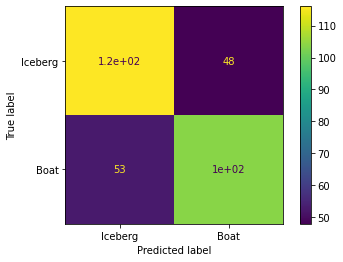

In [70]:
cross_report(DecisionTreeClassifier(min_samples_leaf = 3))

## Nearest Neighbors
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

---
Best parameters for KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform') :
 {'n_neighbors': 8} with f1 score 0.72
Cross_val mean f1 score 0.719 with std 0.052
Scores for the test sample :
 f1 : 0.749
 precision : 0.706
 recall : 0.796
Confusion matrix for the test sample :


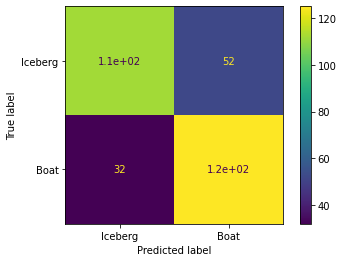

In [76]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = [{
    'n_neighbors': range(4,20,4)
}]
grid_cross_report(KNeighborsClassifier(), param_grid)

## C-Support Vector
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
https://scikit-learn.org/stable/modules/svm.html#svm-kernels

---
Best parameters for SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) :
 {'C': 0.001} with f1 score 0.703
Cross_val mean f1 score 0.702 with std 0.033
Scores for the test sample :
 f1 : 0.726
 precision : 0.719
 recall : 0.732
Confusion matrix for the test sample :


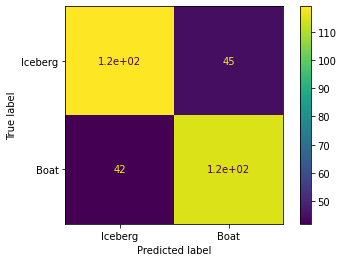

In [81]:
from sklearn.svm import SVC

param_grid = [{
    'C': np.logspace(-3, 0, 4)
}]
grid_cross_report(SVC(kernel='linear'), param_grid)

---
Best parameters for SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) :
 {'C': 1.0} with f1 score 0.764
Cross_val mean f1 score 0.779 with std 0.024
Scores for the test sample :
 f1 : 0.799
 precision : 0.719
 recall : 0.898
Confusion matrix for the test sample :


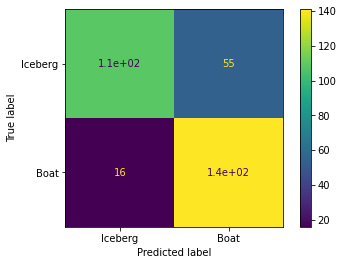

In [82]:
param_grid = [{
    'C': np.logspace(-3, 0, 4)
}]
grid_cross_report(SVC(kernel='rbf', gamma='scale'), param_grid)

---
Best parameters for SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) :
 {'C': 0.001, 'coef0': 0.0} with f1 score 0.0
Cross_val mean f1 score 0.0 with std 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Scores for the test sample :
 f1 : 0.0
 precision : 0.0
 recall : 0.0
Confusion matrix for the test sample :


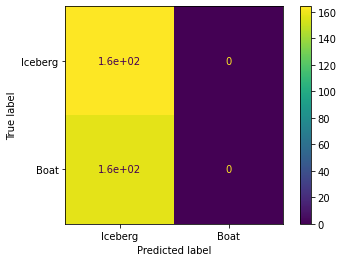

In [84]:
param_grid = [{
    'C': np.logspace(-3, 0, 2),
    'coef0': [0.0,0.1,2.,50.]
}]
grid_cross_report(SVC(kernel='sigmoid', gamma='scale'), param_grid)

## Gaussian Process
https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html#sklearn.gaussian_process.GaussianProcessClassifier

---
GaussianProcessClassifier(copy_X_train=True, kernel=1**2 * RBF(length_scale=1),
                          max_iter_predict=100, multi_class='one_vs_rest',
                          n_jobs=None, n_restarts_optimizer=0,
                          optimizer='fmin_l_bfgs_b', random_state=None,
                          warm_start=False)
Cross_val mean f1 score 0.0 with std 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Scores for the test sample :
 f1 : 0.0
 precision : 0.0
 recall : 0.0
Confusion matrix for the test sample :


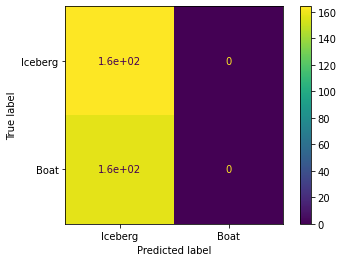

In [87]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

cross_report(GaussianProcessClassifier(1.0 * RBF(1.0)))

## Random Forest
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier

---
Best parameters for RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) :
 {'max_features': 'auto', 'min_samples_leaf': 3, 'n_estimators': 100} with f1 score 0.704
Cross_val mean f1 score 0.702 with std 0.035
Scores for the test sample :
 f1 : 0.772
 precision : 0.738
 recall : 0.809
Confusion matrix for the test sample :


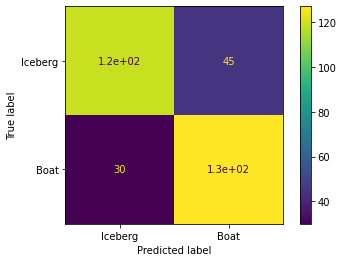

In [88]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [{
    'min_samples_leaf': range(2,4,1),
    'max_features': ['auto'],
    'n_estimators': [100]
}]
grid_cross_report(RandomForestClassifier(), param_grid)

## Neural Net
https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier

---
Best parameters for MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False) :
 {'alpha': 1e-06} with f1 score 0.512
Cross_val mean f1 score 0.47 with std 0.31
Scores for the test sample :
 f1 : 0.675
 precision : 0.51
 recall : 1.0
Confusion matrix for the test sample :


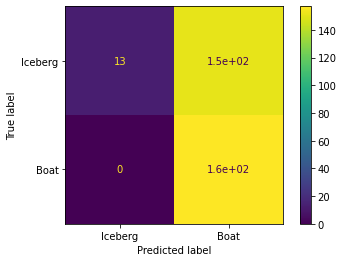

In [95]:
from sklearn.neural_network import MLPClassifier

param_grid = [{
    'alpha': np.logspace(-6, 0, 4)
}]
grid_cross_report(MLPClassifier(), param_grid)

Scores for the test sample :
 f1 : 0.657
 precision : 0.489
 recall : 1.0
Confusion matrix for the test sample :


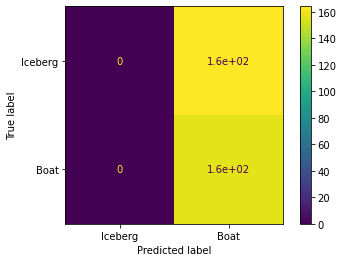

In [96]:
cl = MLPClassifier(alpha = 0.0001)
cl.fit(X_train, y_train)
y_pred = cl.predict(X_test)

print(f'Scores for the test sample :\n f1 : {round(f1_score(y_test, y_pred),3)}\n precision : {round(precision_score(y_test, y_pred),3)}\n recall : {round(recall_score(y_test, y_pred),3)}')

print('Confusion matrix for the test sample :')
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Iceberg','Boat']).plot()

## AdaBoost
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier

---
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Cross_val mean f1 score 0.707 with std 0.05
Scores for the test sample :
 f1 : 0.729
 precision : 0.691
 recall : 0.771
Confusion matrix for the test sample :


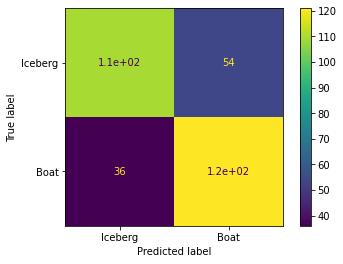

In [97]:
from sklearn.ensemble import AdaBoostClassifier

cross_report(AdaBoostClassifier())

---
AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                      class_weight=None, coef0=0.0,
                                      decision_function_shape='ovr', degree=3,
                                      gamma='scale', kernel='rbf', max_iter=-1,
                                      probability=False, random_state=None,
                                      shrinking=True, tol=0.001,
                                      verbose=False),
                   learning_rate=1.0, n_estimators=50, random_state=None)
Cross_val mean f1 score 0.0 with std 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Scores for the test sample :
 f1 : 0.0
 precision : 0.0
 recall : 0.0
Confusion matrix for the test sample :


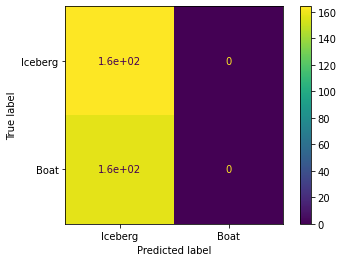

In [99]:
cross_report(AdaBoostClassifier(SVC(C=1., kernel='rbf', gamma='scale'), algorithm='SAMME'))

---
AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=RandomForestClassifier(bootstrap=True,
                                                         ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         max_samples=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=3,
                                                         min_samples_split=2,
                                   

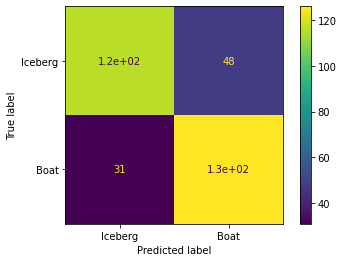

In [101]:
cross_report(AdaBoostClassifier(RandomForestClassifier(min_samples_leaf=3)))

## Naive Bayes
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB

---
GaussianNB(priors=None, var_smoothing=1e-09)
Cross_val mean f1 score 0.672 with std 0.052
Scores for the test sample :
 f1 : 0.668
 precision : 0.579
 recall : 0.79
Confusion matrix for the test sample :


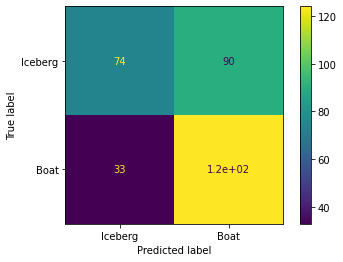

In [103]:
from sklearn.naive_bayes import GaussianNB

cross_report(GaussianNB())

## QDA
https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html#sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning:

Variables are collinear

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning:

Variables are collinear

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning:

Variables are collinear

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning:

Variables are collinear

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning:

Variables are collinear

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning:

Variables are collinear

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning:

Variables are collinear

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning:

Variables are collinear

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:

---
Best parameters for QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001) :
 {'reg_param': 0.6666666666666666} with f1 score 0.662


/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning:

Variables are collinear

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning:

Variables are collinear

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning:

Variables are collinear

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning:

Variables are collinear

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning:

Variables are collinear

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning:

Variables are collinear

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning:

Variables are collinear

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning:

Variables are collinear

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:

Cross_val mean f1 score 0.665 with std 0.007
Scores for the test sample :
 f1 : 0.686
 precision : 0.522
 recall : 1.0
Confusion matrix for the test sample :


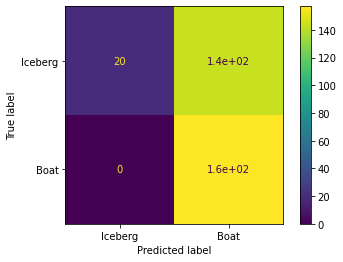

In [110]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

param_grid = [{
    'reg_param': np.linspace(0.0,1.0,4)
}]
grid_cross_report(QuadraticDiscriminantAnalysis(), param_grid)

# Results


## Naive approach

For the Naive approach, the classifiers were ran on the raw data, comprised of the 2 bands of 75*75 pixels.

The best results were reached for the C-Support Vector algorithm (RBF kernel, C=1.0), with a cross-validation mean f1 score of 0.779 and a standard deviation of 0.024. Nonetheless, the test results showed low precision and a high recall, while high precision is preferable. Optimization should also be done on precision, as one might imagine that mis-identifying an iceberg is more dangerous than mis-identifying boat. The linear kernel might offer better precision than the RBF one.

The second best results were found for the K Nearest Neighbors algorithm (8 neighbors), with a cross-validation mean f1 score of 0.719 and a standard deviation of 0.052.

AdaBoost with the Decision Tree classifier showed satisfying results with a cross-validation mean f1 score of 0.707 and a standard deviation of 0.050.

The Random Forest showed satisfying results with a cross-validation mean f1 score of 0.702 and a standard deviation of 0.035, changing to 0.704 and 0.038 with AdaBoost.

The Decision Tree and Naive Bayes showed poor performance for the tested parameters.

The Gaussian Process, Neural Net and QDA showed very poor performances for the tested parameters.